# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [4]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=2000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

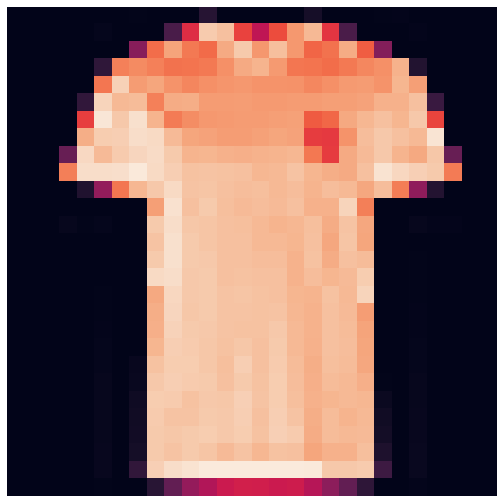

In [6]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

Данные содержат 10 классов


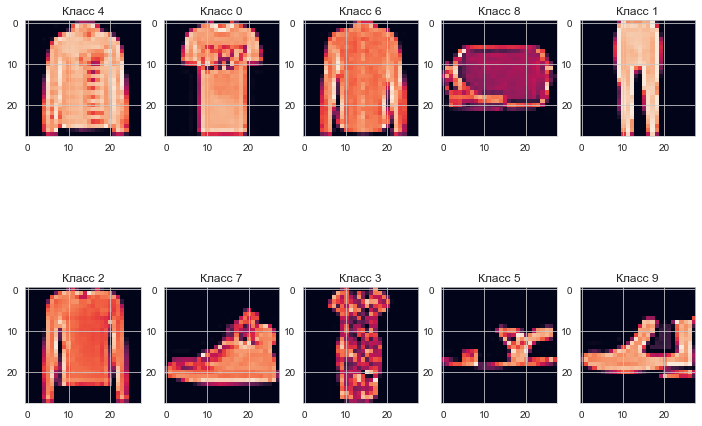

In [7]:
classes = np.unique(y)
print(f'Данные содержат {len(classes)} классов')

# выведем примеры картинок каждого класса
n: int = len(classes)
f = plt.figure()

sample = []
i, j = 400, 0
while len(sample) < 10:
    if y[i] not in sample:
        sample.append(y[i])
        f.add_subplot(2, 5, j + 1)
        plt.imshow(X[i].reshape(28, 28, 1))
        plt.title(f'Класс {y[i]}')
        j += 1
    i += 1       

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

Text(0, 0.5, 'Сount')

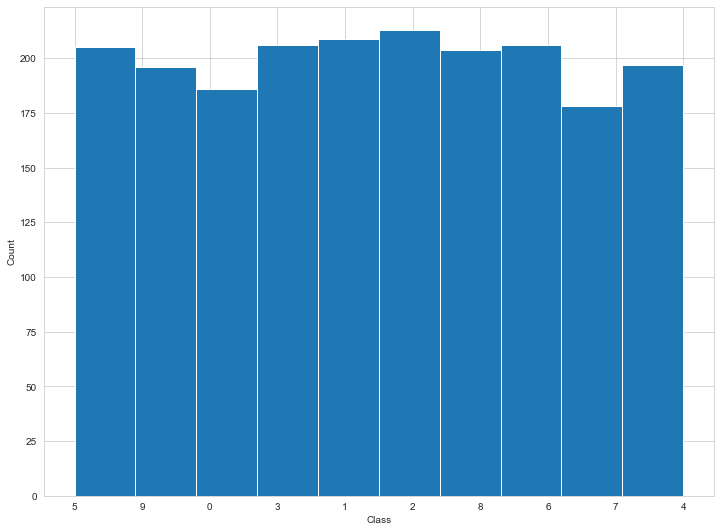

In [8]:
plt.hist(y)
plt.xlabel('Class')
plt.ylabel('Сount')

**В целом классы распределены равномерно**

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [9]:
# переведем целевую переменную в численный формат
y = y.astype(np.int64)

# разделение проведем 3 к 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(len(y_train), len(y_test))

1500 500


### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
indices_to_keep_train = [i for i in range(len(y_train)) if y_train[i] in [1, 0]]
indices_to_keep_test  = [i for i in range(len(y_test)) if y_test[i] in [1, 0]]

binary_train_X, binary_test_X = X_train[indices_to_keep_train], X_test[indices_to_keep_test]
binary_train_y, binary_test_y = y_train[indices_to_keep_train], y_test[indices_to_keep_test]

print(f'Осталось {len(binary_train_y)} объектов в выборке для обучения и {len(binary_test_y)} в тестовой')

Осталось 302 объектов в выборке для обучения и 93 в тестовой


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [12]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [14]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [15]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

108 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.7 ms ± 93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Частичная векторизация дает лучший результат**

Реализуем метод для предсказания меток класса

In [16]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X, n_loops=1)
print(prediction)
print(f'Получены предсказания для {len(prediction)} значений')

[ True False False  True  True  True  True  True False False  True False
 False False False  True False False  True  True  True False False False
  True False  True False  True False False  True False False  True False
  True False False  True  True  True False  True  True  True False False
 False  True False  True False  True  True False False  True False  True
  True False False  True  True  True  True False  True  True  True  True
  True False False  True False  True  True False  True False False  True
  True False False False False  True  True False False]
Получены предсказания для 93 значений


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'Accuracy: {accuracy}')

Precision: 0.9574468085106383
Recall: 1.0
F1 score: 0.9782608695652174
Accuracy: 0.978494623655914


*Все ли хорошо с моделью?*   
Cудя по метрикам, модель идентифицирует все объекты класса 1 (recall), при этом делая около 4% ложноположительных предсказаний (precision). Оптимальность этих значений обманчива, ниже приведены более подробные графики:  
  
Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [19]:
print(f'Соглассно метрикам sklearn:')
print(f'Precision: {precision_score(binary_test_y, prediction)}')
print(f'Recall: {recall_score(binary_test_y, prediction)}')
print(f'F1 score: {f1_score(binary_test_y, prediction)}')
print(f'Accuracy: {accuracy_score(binary_test_y, prediction)}')

Соглассно метрикам sklearn:
Precision: 0.9574468085106383
Recall: 1.0
F1 score: 0.9782608695652174
Accuracy: 0.978494623655914


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [20]:
def find_best_k(X_train, y_train, X_test, y_test, params, metrics):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    available_metrics = ['precision_score', 'recall_score', 'f1_score', 'accuracy_score']
    metrics_idx = [available_metrics.index(i) for i in metrics]
    
    train_metrics = []
    test_metrics = []
    
    # создание модели и рассчет метрик для разных k
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)
        
        train_metrics.append(np.array(binary_classification_metrics(prediction_train, y_train))[metrics_idx])
        test_metrics.append(np.array(binary_classification_metrics(prediction_test, y_test))[metrics_idx])
    
    return (np.array(train_metrics), np.array(test_metrics))

In [25]:
params = [i for i in range(1, 30)]
metrics = ['precision_score', 'recall_score', 'f1_score', 'accuracy_score']
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, metrics)

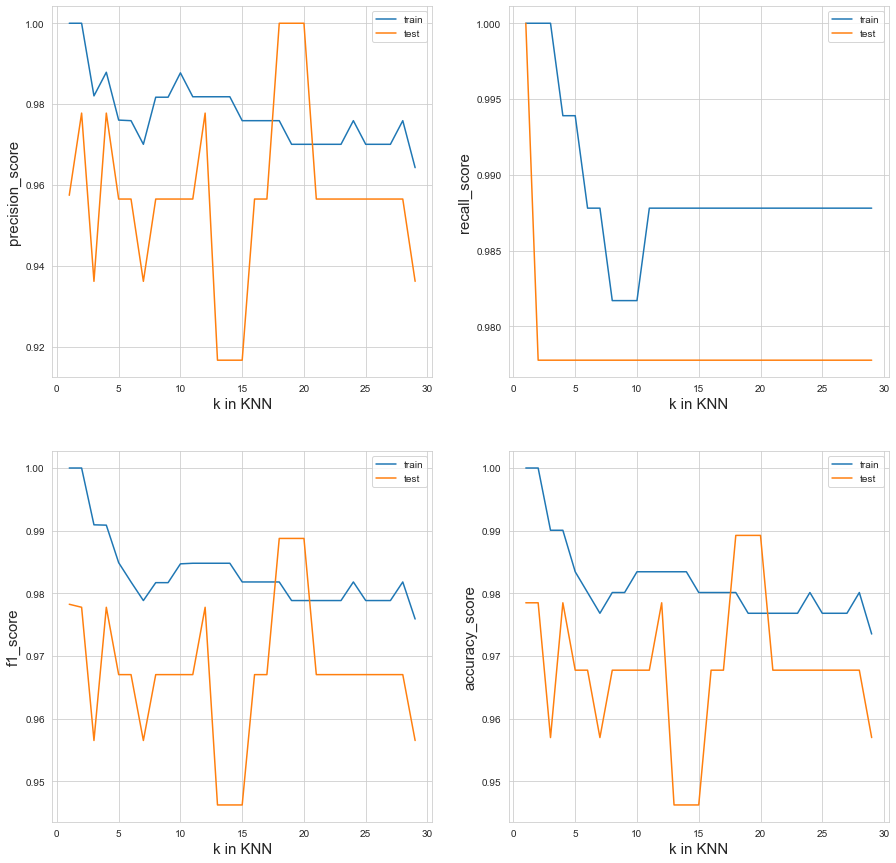

In [26]:
# построим график для каждого вида метрики
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()

for i in range(4):
    ax[i].plot(params, train_metrics[:, i], label="train")
    ax[i].plot(params, test_metrics[:, i], label="test")
    ax[i].legend()
    ax[i].set_xlabel("k in KNN", fontsize = 15)
    ax[i].set_ylabel(metrics[i], fontsize = 15)

Видно, что параметры сильно колеблются, что кажется естественным, так как в многомерном пространстве от параметра k соотношение классов ближайших соседей может зависеть совсем немонотонно

**Вывод: k равное 19 или 20 представляется оптимальным**

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [27]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test, n_loops=1)
print(f'Получено предсказание класса для {len(predictions)} элементов')

Получено предсказание класса для 500 элементов


Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [28]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.744

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

Text(0, 0.5, 'milticlass accuracy')

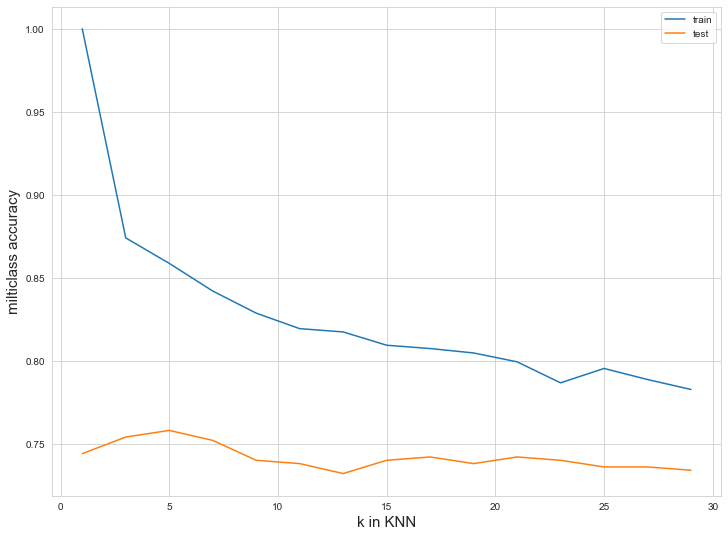

In [30]:
def find_best_milticlass_k(X_train, y_train, X_test, y_test, params):
    train_metrics = []
    test_metrics = []
    
    # создание модели и рассчет метрик для разных k
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)
        
        train_metrics.append(multiclass_accuracy(prediction_train, y_train))
        test_metrics.append(multiclass_accuracy(prediction_test, y_test))
    
    return (np.array(train_metrics), np.array(test_metrics))

params = [i for i in range(1, 30, 2)]
train_metrics, test_metrics = find_best_milticlass_k(X_train, y_train, X_test, y_test, params)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("k in KNN", fontsize = 15)
plt.ylabel("milticlass accuracy", fontsize = 15)

**В этом случае k равное 5 оказывается наилучшим вариантом**

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [31]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [32]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [33]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


Пропусков в данных нет. Всего 442 измерения

In [36]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


In [37]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

Видно, что данные в датасете уже прошли предобработку. Переменные имеют одинаковое std и средние значения блихкие к 0 (с одинаковым порядком десятичного множителя). Их этого можно заключить, что станартизация данных в этом случае не нужна.  
Изобразим это графически:

<AxesSubplot:>

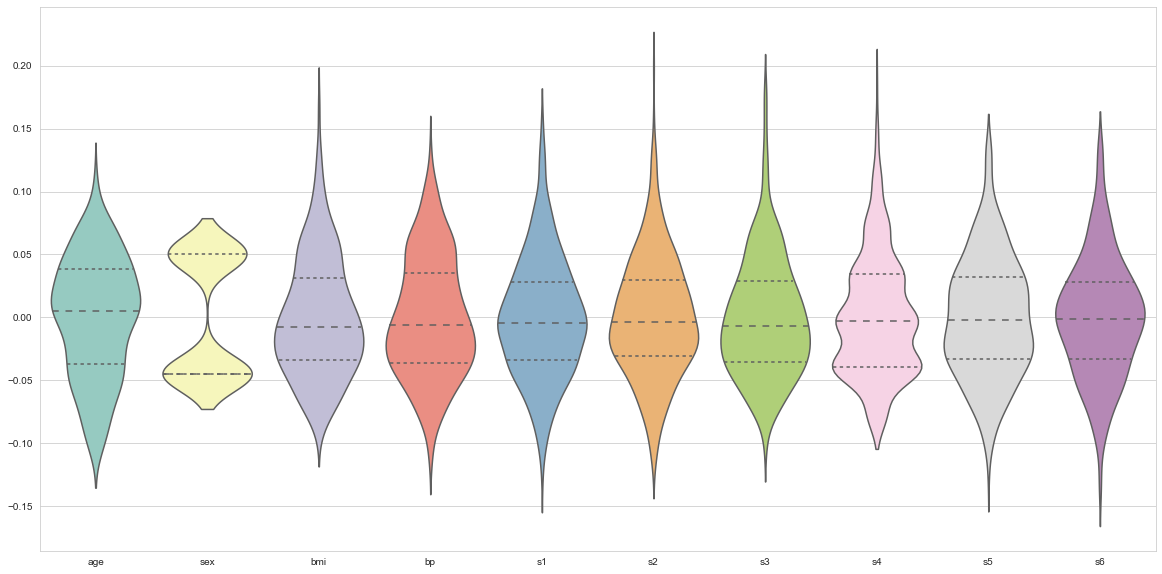

In [38]:
# violin plot
plt.figure(figsize=(20,10))
sns.violinplot(data=X, inner="quartile", scale="width", palette="Set3")

Отчетливо видна бимодальность распределения sex, но это вполне ожидаемо. Намек на би/мультимодальность есть и в других переменных. В целом видно, что диапазоны переменных преимущественно перекрываются, так что необходимости в стандартизации нет

<AxesSubplot:>

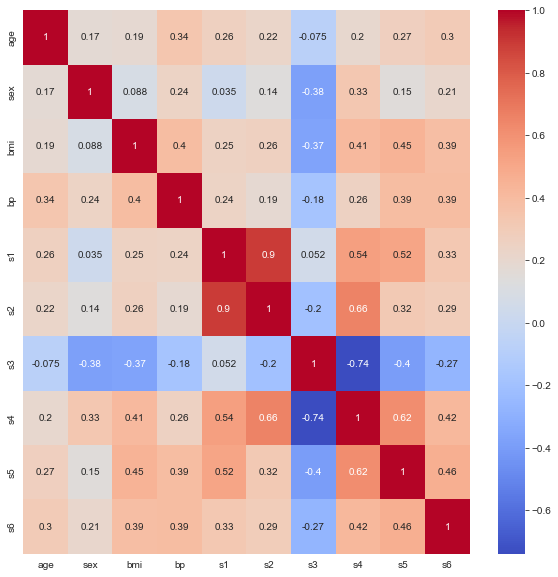

In [39]:
# корреляция между переменными 
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(), cmap="coolwarm", annot = True)

Видно, что s1 сильно скоррелирован с s2, а s3 с s4. Возможно один из дескрипторов в каждой паре можно убрать без значительной потери качества модели. Для отсеивания можно использовать разные алгоритмы, к примеру можно редуцировать количество переменных при помощи PCA

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [40]:
# разбиение на train-test 4 к 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(y_train), len(y_test))

353 89


In [41]:
# для пробы возьмем параметры по умолчанию, хотя в описании их довольно много, можно даже алгоритм варьировать
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
pred_y = neigh.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [43]:
# TODO: r_squared, mse, mae in metrics.py
from metrics import r_squared, mse, mae

print(f'R2: {r_squared(pred_y, np.array(y_test))}')
print(f'MSE: {mse(pred_y, np.array(y_test))}')
print(f'MAE: {mae(pred_y, np.array(y_test))}')

R2: 0.36498737331014663
MSE: 3364.3932584269664
MAE: 44.198501872659186


R2 имеет весьма умеренное значение, а MAE довольно велика по отношению к знаечниям целевой переменной

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.  
Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше. 

In [46]:
train_metrics = []
test_metrics = []
params = [i for i in range(1, 30)]

# создание модели и рассчет метрик для разных k
for k in params:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)

    prediction_test = neigh.predict(X_test)
    prediction_train = neigh.predict(X_train)

    train_metrics.append(np.array([r_squared(prediction_train, np.array(y_train)),
                                   mse(prediction_train, np.array(y_train)), 
                                   mae(prediction_train, np.array(y_train))]))
    
    test_metrics.append(np.array([r_squared(prediction_test, np.array(y_test)),
                                   mse(prediction_test, np.array(y_test)), 
                                   mae(prediction_test, np.array(y_test))]))

train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

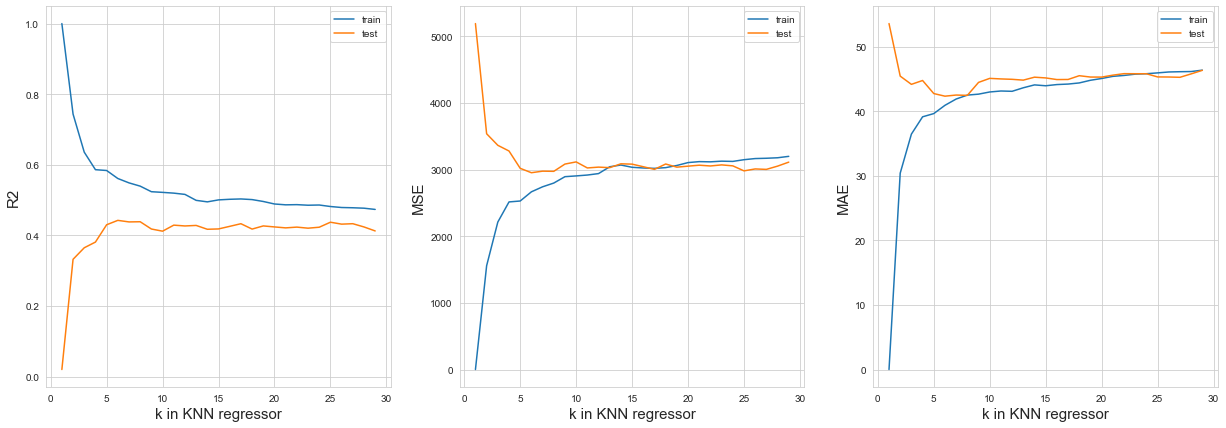

In [47]:
# построим график для каждого вида метрики
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax = ax.flatten()

labels = ['R2', 'MSE', 'MAE']
for i in range(3):
    ax[i].plot(params, train_metrics[:, i], label="train")
    ax[i].plot(params, test_metrics[:, i], label="test")
    ax[i].legend()
    ax[i].set_xlabel("k in KNN regressor", fontsize = 15)
    ax[i].set_ylabel(labels[i], fontsize = 15)

**Из графиков видно, что максимальному значению R2 и минимальным MSE, MAE соответствует k равное 7** (хотя дальнейшее увеличение k несильно меняет ситуацию).  
  
### Реализуем поиск параметров с использованием pipeline и GridSearchCV:

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [49]:
# определим шаги в пайплайне
# здесь добавим scaler для сравнения
steps = [('scaler', StandardScaler()), ('knn_regressor', KNeighborsRegressor())]

# создание объекта pipeline
pipeline = Pipeline(steps)

# зададим параметры для оптимизации нашей модели, ради интереса будем оптимизировать не только k
# изучим, улучшает ли модель неравномерное распределение весов 
# или использование разных метрик (расстрояние манхетена vs евклидово)
k_values = [i for i in range(1, 30, 2)]
parameteres = {'knn_regressor__n_neighbors': k_values,
               'knn_regressor__weights': ['uniform', 'distance'],
               'knn_regressor__p': [1, 2]}

# инициализируем поиск ооптимальных параметров с 5-fold кросс-валидацией 
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

# поиск оптимальных параметров
grid.fit(X_train, y_train)
print(f"score = {grid.score(X_test,y_test)}")
print(grid.best_params_)

score = 0.4413022097187317
{'knn_regressor__n_neighbors': 19, 'knn_regressor__p': 2, 'knn_regressor__weights': 'distance'}


Ремарка: scaler ыключен в пайплайн и работает, как и требует задание. Если бы мы использовали его отдельно, то надобыло бы писать так:  
  
`scale = StandardScaler().fit(X_train)` создание scaler и задание ему параметров на обучающей выборке  
  
`X_train_scaled = scale.transform(X_train)` шкалирование test и train сетов  
`X_test_scaled = scale.transform(X_test)` 
  
Посмотрим каких метрик добивается модель с оптимальными парамиетрами:

In [50]:
pipeline = Pipeline([('scaler', StandardScaler()),
                 ('knn_regressor', KNeighborsRegressor(n_neighbors = 19, weights='distance', p=2))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f'R2: {r_squared(y_pred, np.array(y_test))}')
print(f'MSE: {mse(y_pred, np.array(y_test))}')
print(f'MAE: {mae(y_pred, np.array(y_test))}')

R2: 0.4413022097187317
MSE: 2960.065674471063
MAE: 44.73470887515684


Тут явно видно, что для наших данных стандартизация в принципе не нужна, но она влияет на оптимальное число параметров. Так если запустить регрессор без стандартизации с теми же параметрами, получим несколько худшие метрики:

In [51]:
neigh = KNeighborsRegressor(n_neighbors = 19, weights='distance', p=2)

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(f'R2: {r_squared(y_pred, np.array(y_test))}')
print(f'MSE: {mse(y_pred, np.array(y_test))}')
print(f'MAE: {mae(y_pred, np.array(y_test))}')

R2: 0.4374903655885438
MSE: 2980.2614031144913
MAE: 44.705409634191504


**Но результат можно улучшить изменив параметры. Но в любом случае принципиальной разницы в метриках нет**

In [52]:
knn_regressor = KNeighborsRegressor()

# инициализируем поиск оптимальных параметров с 5-fold кросс-валидацией 
k_values = [i for i in range(1, 30, 2)]
parameteres = {'n_neighbors': k_values,
               'weights': ['uniform', 'distance'],
               'p': [1, 2]}
grid = GridSearchCV(knn_regressor, param_grid=parameteres, cv=5)

# поиск оптимальных параметров
grid.fit(X_train, y_train)
print(f"score = {grid.score(X_test, y_test)}")
print(grid.best_params_)

score = 0.44405047992626
{'n_neighbors': 17, 'p': 2, 'weights': 'distance'}


In [60]:
neigh = KNeighborsRegressor(n_neighbors = 17, weights='distance', p=2)
# кстати тут при k=7 метрики практически идентичны, разница в R2 в третьем знаке

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(f'R2: {r_squared(y_pred, np.array(y_test))}')
print(f'MSE: {mse(y_pred, np.array(y_test))}')
print(f'MAE: {mae(y_pred, np.array(y_test))}')

R2: 0.44405047992626
MSE: 2945.504921865651
MAE: 44.289449492653056


### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**
- В целом мне очень понравилось, как оформлено дз. Видно, что сил и внимания вложено очень много, спасибо! Понравились наводки на разные методы, к примену на pipeline. Полезно и интересно
- Кстати, столкнулся с нюансом импорта функций и классов из .py. Они не обновляются при обновлении файла простым реимпортом, лайвхаки со stackoverflow тоже не помогли. Только перезапуск ядра. Поэтому пришлось скопировать код в ячейки и уже в конце перенести его в py. Но на таких нюансах как раз и учишься!  
   
     
- Дз довольно объемное, хоть и полезное. У меня есть довлльно таки постоянная практика работы с numpy, sklearn и pandas, и то я три вечера сидел оформлял все, пробовал и тд. Когда подъедут мини-проекты, НИР и филогенетика, то может быть тяжко..
- Далеко не у всех биологов есть входное понимание numpy, sklearn и pandas, поэтому это очень сильно сбивает с толку. Мне кажется, это можно преодолеть дополнительной координацией между курсами: можно делать какие-то задачи c numpy и pandas уже в первом семестре, дать какие-нибудь онлайн-блоки на степике. Или сделать это мини-заданием на каникулы вместо проекта. Тогда возможно не будет такого сильного входного шока